# 01 - Cleaning and EDA

## **_!! in progress !!_**

To be able to run this script, you must donwload the data.

</br>

The link is provided in the README.md:
> Dataset involved in this project:
> 
> > https://drive.google.com/drive/folders/1Ki4-020vszEdzjNAOPx5KHjTNjndhYER?usp=sharing

</br>

STEPS:

- Data analysis: It means studying the characteristics of the datasets. (e.g., image acquisition processes, labeling quality, size, and area of bounding boxes, image quality, number of samples, etc.)

- Data cleaning: It is the process to identify incomplete, incorrect, or inaccurate data, and then replacing, modifying, or deleting it.

- Data splitting: When splitting the dataset (train, validation) it is important to take into account the equitable distribution of classes.

<!-- - Data augmentation: Most Deep Learning algorithms need huge quantities of data to achieve interesting results. Data augmentation can improve the generalization and reduce the over-fitting of models by making different variations of the same image. Ex: flipping, rotations, padding, cropping, gaussian noise injection, random erasing, etc.
 -->


## Assessing data quality:

Visualize multiple images at the same time. Focus on size, orientation, brightness, background variations, etc.

<!-- Make sure there are no corrupted files (ex. images that cannot be opened). -->

Take note of the different extensions: jpg, jpeg, jpe, png, tif, tiff, bmp, ppm, pbm, pgm, sr, ras, webp.

Verify that all images share the same color model: RGB, grayscale, etc.

- Applied recommendations:

From the scrapped images, only the ones that had a sufficiently high quality and at the same time showed damages within economic repair were selected. Also, duplicates were removed and all images were converted to the chosen format: JPG.


## Visualize image size and aspect ratio:

Make a histogram to visualize the distribution of image size and aspect ratio (Figure 4).
If the majority of images have a uniform distribution (same dimensions), then it is up to you to decide how much to alter them. You can start by using the average size and aspect ratio or taking into account the minimum image size accepted by your chosen algorithm.
If the distribution is bimodal (has two peaks), then you can alter the images by adding some padding. 
If the distribution is random (images very wide and very narrow), it is better to use advanced techniques to avoid altering the aspect ratio.
Pick a consistent image size: large enough to keep features distinguishable, but not too large to run out of memory.

#### Reference:
- https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a
- https://www.kaggle.com/code/jpmiller/basic-eda-with-images
- https://www.omdena.com/blog/a-guide-to-using-eda-for-vehicle-image-analysis-and-insurance-fraud-prevention





In [1]:
import os, os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Evalueating the data

Let's see how many classes the dataset have:

In [2]:

directory = '../datasets/dataset_normal'

lst = os.listdir(directory) # your directory path
print(lst)

number_files = len(lst)
print(number_files)


['basophil', 'neutrophil', 'ig', 'monocyte', 'eosinophil', 'erythroblast', 'lymphocyte', 'platelet']
8


As we can see from above, we have 8.

They are:

- basophil
- neutrophil
- ig
- monocyte
- eosinophil
- erythroblast
- lymphocyte
- platelet


Let's see how much clean data it have:

In [3]:
#pass the dir in your dataset
directory = '../datasets/dataset_normal'

dir = next(os.walk(directory))[1] #directory is your directory path as string
# onlyfiles = next(os.walk(directory))[2] #files is your directory path as string

number_classes = {}

for i,e in enumerate(dir):
    insideDir = next(os.walk(directory+"/"+e))[2]
    number_classes[e] = len(insideDir)
    
print(number_classes)



{'basophil': 1218, 'neutrophil': 3329, 'ig': 2895, 'monocyte': 1420, 'eosinophil': 3117, 'erythroblast': 1551, 'lymphocyte': 1214, 'platelet': 2348}


Let's plot to be easyer to vizualize:

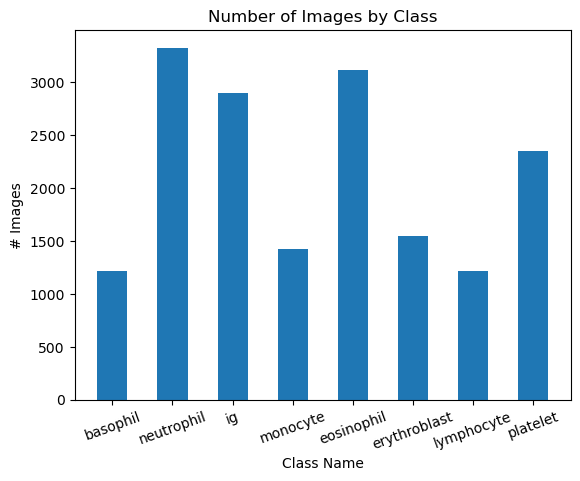

In [4]:
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.xticks(rotation=20)
plt.xlabel('Class Name');
plt.ylabel('# Images');
plt.title("Number of Images by Class");


From the graph above we can see that the data is not normalized between the classes, but even cutting down by the lower we still have more than 1000 images per class.

For the next step let's see the size of the images:

In [6]:
#pass the dir in your dataset
directory = '../datasets/dataset_normal'

dirs = next(os.walk(directory))[1] #directory is your directory path as string
# onlyfiles = next(os.walk(directory))[2] #files is your directory path as string

directories = {}

for i,e in enumerate(dirs):
    insideDir = next(os.walk(directory+"/"+e))[2]
    directories[e] = directory+"/"+e+"/"
    
print(directories)


{'basophil': '../datasets/dataset_normal/basophil/', 'neutrophil': '../datasets/dataset_normal/neutrophil/', 'ig': '../datasets/dataset_normal/ig/', 'monocyte': '../datasets/dataset_normal/monocyte/', 'eosinophil': '../datasets/dataset_normal/eosinophil/', 'erythroblast': '../datasets/dataset_normal/erythroblast/', 'lymphocyte': '../datasets/dataset_normal/lymphocyte/', 'platelet': '../datasets/dataset_normal/platelet/'}


In [7]:
from PIL import Image 

def get_dims(file):
    '''Returns dimenstions for an RBG image'''
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w


[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.8s


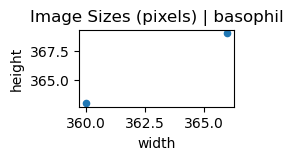

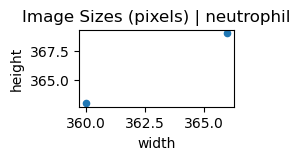

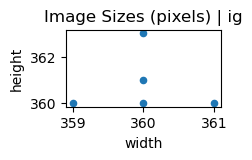

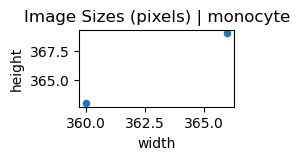

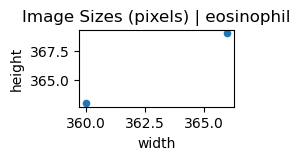

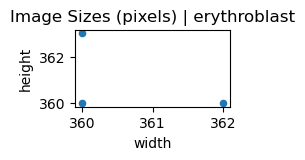

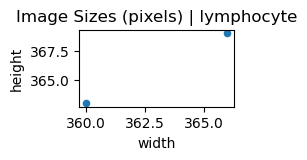

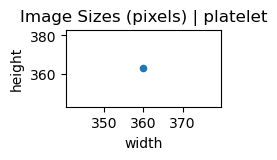

In [8]:
from dask import bag, diagnostics 

for i,e in directories.items():
    filepath = e
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height',
                           figsize=(2, 1)
                          );
        plt.title('Image Sizes (pixels) | {}'.format(i))


From the graphs above we conclude that the images are about the same size. But they are not the same, so we have to do some crop with the images to insert into the model.

## Format of the files

Let's see if all the files are in the same format:

In [14]:
objExt = {}

for i,e in directories.items():
    filepath = e
    filelist = [filepath + f for f in os.listdir(filepath)]

    for file in filelist:
        name, extension = os.path.splitext(file)

        if extension not in objExt:
            objExt[extension] = 0
        else:
            objExt[extension] +=1
        
print(objExt)

{'.jpg': 17091}


As we can see from the result from the code above, we have all files in .jpg

Taking a look into the images from the dataset

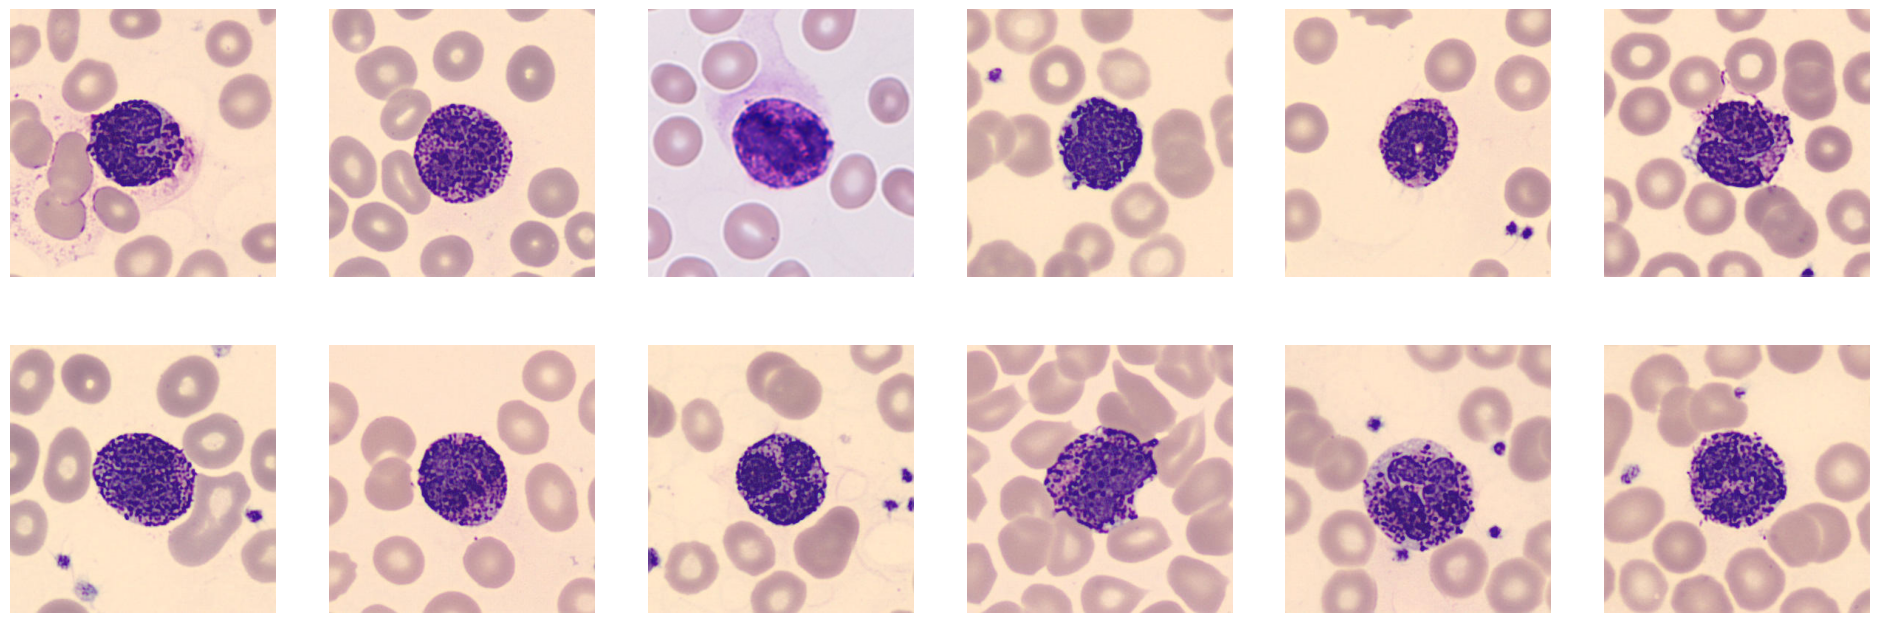

In [17]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_directory = '../datasets/dataset_normal/basophil/'
ncols = 6  # Number of columns in the grid
nrows = 2  # Number of rows in the grid

def show_image_sample(pic_directory):
    '''display 4x4 images'''
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    image_files = os.listdir(pic_directory)[:nrows * ncols]

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(pic_directory, img_file)
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        img = mpimg.imread(img_path)
        plt.imshow(img)

    plt.show()

show_image_sample(pic_directory)


In [15]:
# TODO:
# Evaluate the:

#     - Colors